## NLP & Sentiment Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import json
import heapq
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tqdm import tqdm
tqdm.pandas()
import os

# Data Preparation

In [2]:
# convert json file into dataframe

reviews = []
for line in open('reviews_Health_and_Personal_Care_5.json', 'r'):
    reviews.append(json.loads(line))

reviews_df = pd.DataFrame(reviews)

reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]",This is a great little gadget to have around. ...,5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier ...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and t...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]",Love the Great point light pocket magnifier! ...,4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]",This is very nice. You pull out on the magnifi...,5.0,Very nice and convenient.,1313452800,"08 16, 2011"


In [3]:
# Extract only relevant data from the original dataset
review_data = reviews_df[["reviewerID","reviewText","overall"]]
review_data.head()

,reviewerID,reviewText,overall
0,ALC5GH8CAMAI7,This is a great little gadget to have around. ...,5.0
1,AHKSURW85PJUE,I would recommend this for a travel magnifier ...,4.0
2,A38RMU1Y5TDP9,What I liked was the quality of the lens and t...,4.0
3,A1XZUG7DFXXOS4,Love the Great point light pocket magnifier! ...,4.0
4,A1MS3M7M7AM13X,This is very nice. You pull out on the magnifi...,5.0


In [5]:
review_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346355 entries, 0 to 346354
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   reviewerID  346355 non-null  object 
 1   reviewText  346355 non-null  object 
 2   overall     346355 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.9+ MB


Refine the text data

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/jihyunkim/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
# Change text to lower case
review_data["reviewText"]=review_data["reviewText"].astype(str).str.lower()

/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/2739571752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data["reviewText"]=review_data["reviewText"].astype(str).str.lower()


In [8]:
#tokenize words
review_data['reviewText'] = review_data.progress_apply(lambda row: word_tokenize(row['reviewText']), axis=1)

100%|██████████| 346355/346355 [01:39<00:00, 3488.64it/s]
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/655907805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['reviewText'] = review_data.progress_apply(lambda row: word_tokenize(row['reviewText']), axis=1)


In [9]:
#handle negation
review_data["reviewText"] = review_data["reviewText"].progress_apply(lambda x: ['not' if a =="n't" else a for a in x])

100%|██████████| 346355/346355 [00:02<00:00, 144686.73it/s]
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/1052244429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data["reviewText"] = review_data["reviewText"].progress_apply(lambda x: ['not' if a =="n't" else a for a in x])


In [10]:
review_data.head()

,reviewerID,reviewText,overall
0,ALC5GH8CAMAI7,"[this, is, a, great, little, gadget, to, have,...",5.0
1,AHKSURW85PJUE,"[i, would, recommend, this, for, a, travel, ma...",4.0
2,A38RMU1Y5TDP9,"[what, i, liked, was, the, quality, of, the, l...",4.0
3,A1XZUG7DFXXOS4,"[love, the, great, point, light, pocket, magni...",4.0
4,A1MS3M7M7AM13X,"[this, is, very, nice, ., you, pull, out, on, ...",5.0


In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jihyunkim/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
#removing stop words
stop = stopwords.words('english')
review_data['reviewText'] = review_data['reviewText'].progress_apply(lambda x: [a for a in x if a not in stop])

100%|██████████| 346355/346355 [00:24<00:00, 14278.61it/s]
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/2771996315.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['reviewText'] = review_data['reviewText'].progress_apply(lambda x: [a for a in x if a not in stop])


In [13]:
#removing punctuation and symbols
review_data["reviewText"] = review_data['reviewText'].progress_apply(lambda x: [a for a in x if a.isalpha()])

100%|██████████| 346355/346355 [00:02<00:00, 123051.71it/s]
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/3574156866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data["reviewText"] = review_data['reviewText'].progress_apply(lambda x: [a for a in x if a.isalpha()])


In [14]:
#stemming words
ps = PorterStemmer()
review_data['reviewText'] = review_data['reviewText'].progress_apply(lambda x : [ps.stem(a) for a in x])

100%|██████████| 346355/346355 [02:03<00:00, 2811.88it/s]
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/2789820749.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['reviewText'] = review_data['reviewText'].progress_apply(lambda x : [ps.stem(a) for a in x])


In [15]:
#joining words back
review_data["reviewText"] = review_data["reviewText"].progress_apply(lambda x: str(' '.join(x)))

100%|██████████| 346355/346355 [00:00<00:00, 757981.70it/s]
/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/3232170542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data["reviewText"] = review_data["reviewText"].progress_apply(lambda x: str(' '.join(x)))


In [16]:
review_data.head()

,reviewerID,reviewText,overall
0,ALC5GH8CAMAI7,great littl gadget around alreadi use look spl...,5.0
1,AHKSURW85PJUE,would recommend travel magnifi occasion read a...,4.0
2,A38RMU1Y5TDP9,like qualiti len built light len discern disto...,4.0
3,A1XZUG7DFXXOS4,love great point light pocket magnifi work gre...,4.0
4,A1MS3M7M7AM13X,nice pull magnifi want light come slide back w...,5.0


In [17]:
# Map ratings to sentiments
# A rating of 4 or 5 = positive sentiment 1
# A rating of 1 or 2 = negative sentiment 0

sentiment = {1: 0, 2: 0, 4: 1, 5: 1}
review_data["sentiment"] = review_data["overall"].map(sentiment)

review_data.head()

/var/folders/qk/cp6vzsf56nsb8yd0n4typwx00000gn/T/ipykernel_42025/1511312011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data["sentiment"] = review_data["overall"].map(sentiment)


,reviewerID,reviewText,overall,sentiment
0,ALC5GH8CAMAI7,great littl gadget around alreadi use look spl...,5.0,1.0
1,AHKSURW85PJUE,would recommend travel magnifi occasion read a...,4.0,1.0
2,A38RMU1Y5TDP9,like qualiti len built light len discern disto...,4.0,1.0
3,A1XZUG7DFXXOS4,love great point light pocket magnifi work gre...,4.0,1.0
4,A1MS3M7M7AM13X,nice pull magnifi want light come slide back w...,5.0,1.0


In [18]:
# Check if the data is well balanced
len(review_data[review_data["sentiment"]==0]),len(review_data[review_data["sentiment"]==1]) # The data is imbalanced

(33300, 279801)

In [19]:
# Randomly create samples to address data imbalance
review_positive = review_data[review_data['sentiment']==1]
review_negative = review_data[review_data['sentiment']==0]

new_reviews = pd.concat([review_positive.sample(n=10000, random_state=1), review_negative.sample(n=10000, random_state=1)])

new_reviews.head()

,reviewerID,reviewText,overall,sentiment
148308,A2MU3FLFSWW4TD,use pay twice much network market scheme man i...,5.0,1.0
14870,A2WL9KZ9JXRTHQ,make great product yogurt quit tasti clean fre...,5.0,1.0
315518,A27GPXG538KWHU,use anoth major brand omega capsul decid tri d...,5.0,1.0
196317,A4E9H23O2Q9SR,like thing pretti comfort definit add support ...,4.0,1.0
269638,A27Q1X75QCWTID,usual use mach kind razor excit tri girli razo...,4.0,1.0


In [20]:
len(new_reviews[new_reviews["sentiment"]==0]),len(new_reviews[new_reviews["sentiment"]==1])

(10000, 10000)

# Text vetorization: Bag of Words

In [21]:
#Creating table of 500 most common words
word_freq = {}
for review in new_reviews['reviewText']:
    for word in review.split(' '):
        if word not in word_freq.keys():
            word_freq[word] = 1
        else:
            word_freq[word] += 1

word_vector = heapq.nlargest(500, word_freq, key=word_freq.get)

def word_vectors(review):
    review_vec = []
    for word in word_vector:
        if word in review.split(' '):
            review_vec.append(1)
        else:
            review_vec.append(0)
    return review_vec

new_reviews["bagofwords"] = new_reviews["reviewText"].progress_apply(word_vectors)

100%|██████████| 20000/20000 [00:09<00:00, 2083.33it/s]


In [22]:
new_reviews.head()

,reviewerID,reviewText,overall,sentiment,bagofwords
148308,A2MU3FLFSWW4TD,use pay twice much network market scheme man i...,5.0,1.0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14870,A2WL9KZ9JXRTHQ,make great product yogurt quit tasti clean fre...,5.0,1.0,"[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
315518,A27GPXG538KWHU,use anoth major brand omega capsul decid tri d...,5.0,1.0,"[1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
196317,A4E9H23O2Q9SR,like thing pretti comfort definit add support ...,4.0,1.0,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ..."
269638,A27Q1X75QCWTID,usual use mach kind razor excit tri girli razo...,4.0,1.0,"[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, ..."


In [23]:
bagofwords = pd.DataFrame(new_reviews["bagofwords"].values.tolist(),columns = word_vector,index = new_reviews["reviewerID"])

In [24]:
bagofwords.head()

,use,product,like,one,work,get,would,tri,take,good,...,rins,basic,name,ask,monitor,huge,immedi,arriv,smaller,updat
reviewerID,,,,,,,,,,,,,,,,,,,,,
A2MU3FLFSWW4TD,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A2WL9KZ9JXRTHQ,1,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A27GPXG538KWHU,1,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A4E9H23O2Q9SR,1,0,1,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A27Q1X75QCWTID,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Text vetorization: TF-IDF

In [25]:
vectorizer_tfidf = TfidfVectorizer(max_df=0.9)
tfidf = vectorizer_tfidf.fit_transform(new_reviews["reviewText"])

tfidf

<20000x20746 sparse matrix of type '<class 'numpy.float64'>'
	with 718712 stored elements in Compressed Sparse Row format>

# Text vetorization: nGrams

In [26]:
vectorizer_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,2), max_df=0.9)
ngram = vectorizer_ngram.fit_transform(new_reviews['reviewText'])

ngram

<20000x474510 sparse matrix of type '<class 'numpy.float64'>'
	with 867305 stored elements in Compressed Sparse Row format>

# Sentiment Analysis Predictive Models

# Logistic Regression (With GridSearchCV)

In [31]:
def logisticCV(data, hyperparameters):
    x_train, x_test, y_train, y_test = train_test_split(data,
                                                        new_reviews["sentiment"],
                                                        test_size=0.3, random_state=9)

    logreg = GridSearchCV(LogisticRegression(), hyperparameters, cv=2, refit=True)
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    bestparams = logreg.best_params_

    logreg_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % logreg_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return bestparams, confusion, report, plt.show()

hyperparas = {'C': np.logspace(-2, 4, 10)}

[[2366  677]
 [ 630 2327]]
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78      3043
         1.0       0.77      0.79      0.78      2957

    accuracy                           0.78      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.78      0.78      0.78      6000



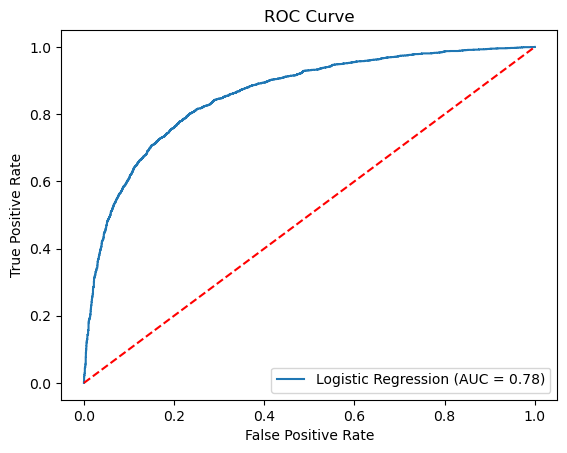

({'C': 0.046415888336127774}, None, None, None)

In [32]:
# Bag of Words
logisticCV(bagofwords, hyperparas)

/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[[2514  529]
 [ 572 2385]]
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82      3043
         1.0       0.82      0.81      0.81      2957

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



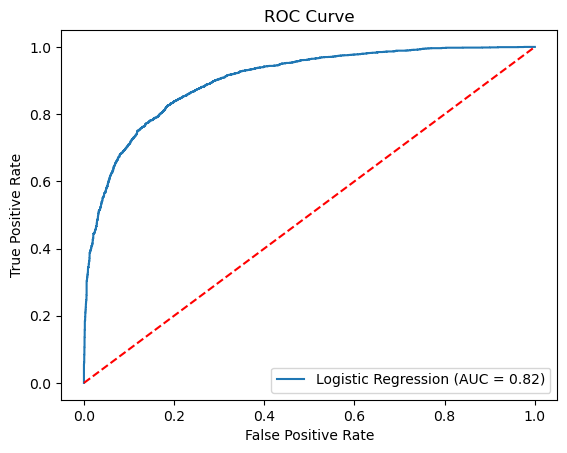

({'C': 1.0}, None, None, None)

In [33]:
# TFIDF
logisticCV(tfidf, hyperparas)

/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

[[2484  559]
 [ 700 2257]]
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80      3043
         1.0       0.80      0.76      0.78      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


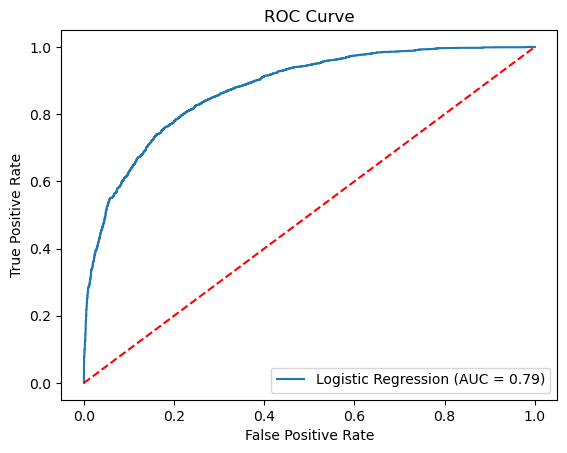

({'C': 100.0}, None, None, None)

In [34]:
# nGram
logisticCV(ngram, hyperparas)

# Random Forest Classifier (With GridSearchCV)

In [35]:
param_grid = {
    'bootstrap': [True],
    'max_features': ['auto', 'sqrt', 'log2'],
    'n_estimators': [100, 200, 300]
}

def rfcCV(data, param):
    x_train, x_test, y_train, y_test = train_test_split(data,
                                                        new_reviews["sentiment"],
                                                        test_size=0.3, random_state=9)
    rfc_cv = GridSearchCV(RandomForestClassifier(), param, cv= 2, refit=True)
    rfc_cv.fit(x_train, y_train)
    y_pred = rfc_cv.predict(x_test)

    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    bestparams = rfc_cv.best_params_

    rfc_cv_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, rfc_cv.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='RFC CV (AUC = %0.2f)' % rfc_cv_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return bestparams, confusion, report, plt.show()

/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
 

[[2438  605]
 [ 681 2276]]
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79      3043
         1.0       0.79      0.77      0.78      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



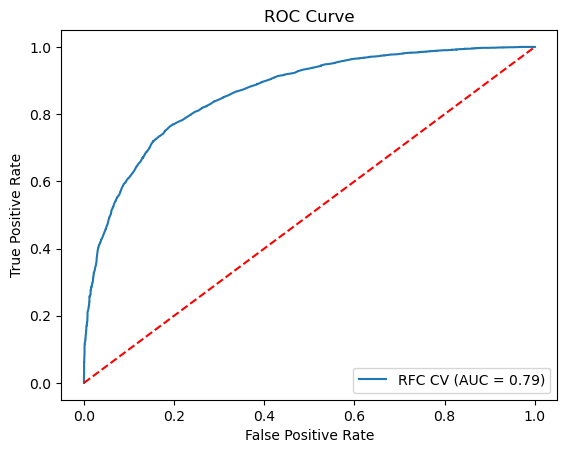

({'bootstrap': True, 'max_features': 'log2', 'n_estimators': 300},
 None,
 None,
 None)

In [36]:
# Bag of Words
rfcCV(bagofwords, param_grid)

/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
 

[[2525  518]
 [ 628 2329]]
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.82      3043
         1.0       0.82      0.79      0.80      2957

    accuracy                           0.81      6000
   macro avg       0.81      0.81      0.81      6000
weighted avg       0.81      0.81      0.81      6000



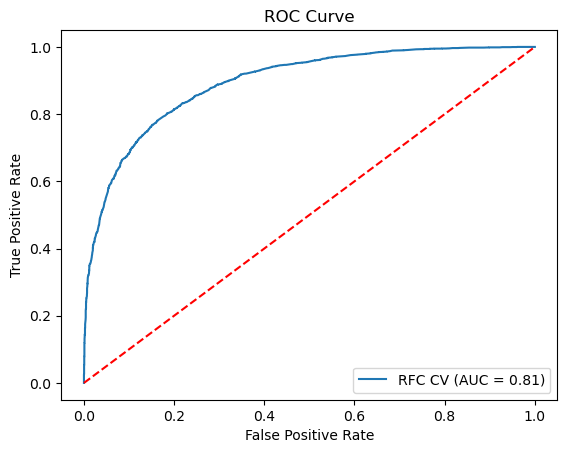

({'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300},
 None,
 None,
 None)

In [37]:
# TFIDF
rfcCV(tfidf, param_grid)

/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
6 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jihyunkim/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
 

[[2616  427]
 [1105 1852]]
              precision    recall  f1-score   support

         0.0       0.70      0.86      0.77      3043
         1.0       0.81      0.63      0.71      2957

    accuracy                           0.74      6000
   macro avg       0.76      0.74      0.74      6000
weighted avg       0.76      0.74      0.74      6000



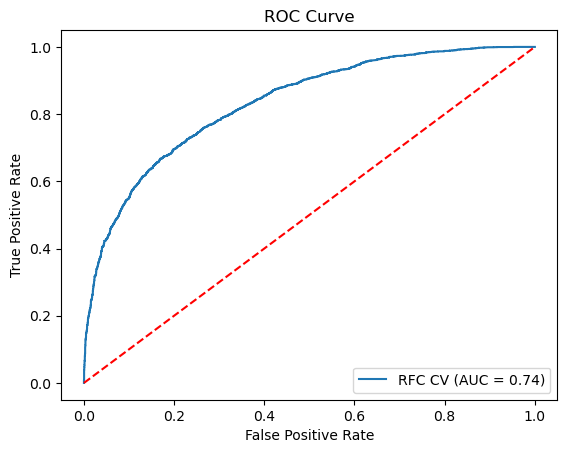

({'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 300},
 None,
 None,
 None)

In [38]:
# nGram
rfcCV(ngram, param_grid)

# Support Vector Machines (With GridSearchCV)

In [39]:
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

def svcCV(data, param):
    x_train, x_test, y_train, y_test = train_test_split(data,
                                                        new_reviews["sentiment"],
                                                        test_size=0.3, random_state=9)

    svc_cv = GridSearchCV(SVC(probability=True), param, cv=2, refit=True)
    svc_cv.fit(x_train, y_train)
    y_pred = svc_cv.predict(x_test)

    confusion = print(confusion_matrix(y_test, y_pred))
    report = print(classification_report(y_test, y_pred))
    bestparams = svc_cv.best_params_

    svc_cv_auc_roc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, svc_cv.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='SVM CV(AUC = %0.2f)' % svc_cv_auc_roc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return bestparams, confusion, report, plt.show()

[[2408  635]
 [ 624 2333]]
              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79      3043
         1.0       0.79      0.79      0.79      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



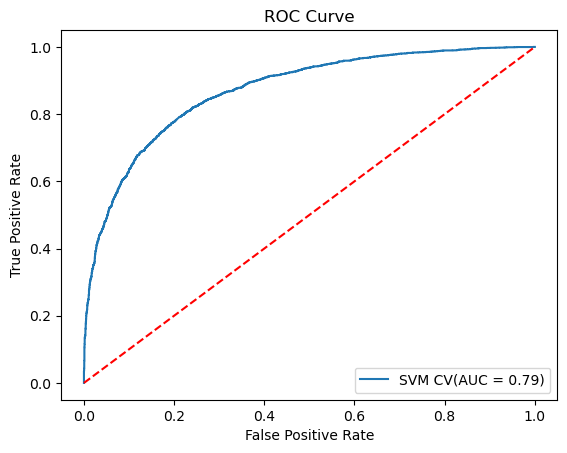

({'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, None, None, None)

In [40]:
# Bag of Words
svcCV(bagofwords, param_grid)

[[2531  512]
 [ 564 2393]]
              precision    recall  f1-score   support

         0.0       0.82      0.83      0.82      3043
         1.0       0.82      0.81      0.82      2957

    accuracy                           0.82      6000
   macro avg       0.82      0.82      0.82      6000
weighted avg       0.82      0.82      0.82      6000



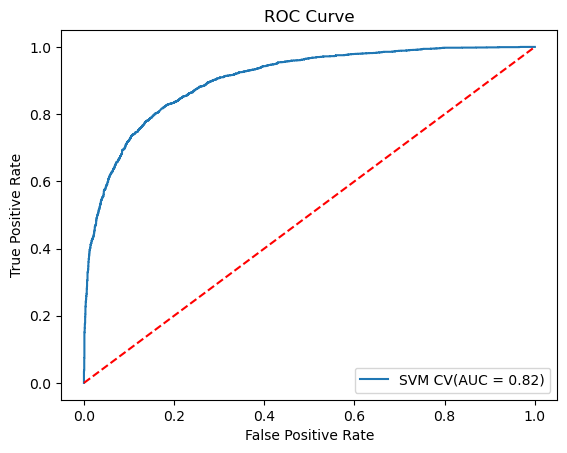

({'C': 1, 'gamma': 1, 'kernel': 'rbf'}, None, None, None)

In [41]:
# TFIDF
svcCV(tfidf, param_grid)

[[2441  602]
 [ 664 2293]]
              precision    recall  f1-score   support

         0.0       0.79      0.80      0.79      3043
         1.0       0.79      0.78      0.78      2957

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.79      0.79      0.79      6000



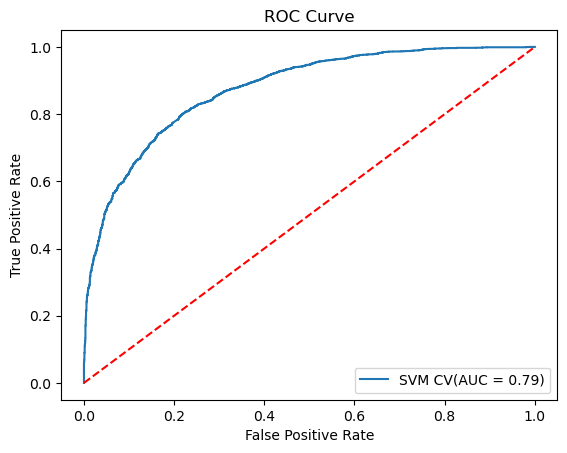

({'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}, None, None, None)

In [42]:
# nGram
svcCV(ngram, param_grid)